# Thermal Freezeout

Beginning with the equation describing the Hubble constant as a function of the temperature,
$$
H(T) = \frac{\pi}{3}\left(\frac{g_*}{10} \right)^{1/2} \frac{T^2}{M_{pl}}
$$
where $M_{pl}$ is the Planck mass, $g_*$ are the effective degrees of freedom and $T$ is the temperature. The form of $g_*$ is
$$
g_* = \sum_{i = b} g_i + \frac{7}{8}\sum_{i=f} g_i
$$
where we are summing over the degrees of freedom of particles which have not decoupled from photons. When $T$ drops below $m_i$, the species $i$ will no longer be included in the sum.

In [2]:
#IMPORTS
from __future__ import division
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sympy.solvers import solve
from sympy import Symbol
from scipy.integrate import odeint
from scipy.optimize import newton
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

#IMPORTS
M_pl = 2.435e18 #GeV
G_F = 1.166e-5
def g_star(Tlist):
    '''Takes temperature in GeV, returns g_eff, numbers found from https://arxiv.org/pdf/1609.04979.pdf'''
    gs = []
    for T in Tlist:
        if T > 170:
            gs.append(106.25)
        if T <= 170 and T > 125: #annihilation of  t, tbar
            gs.append(96.25)
        if T <= 125  and T > 91: #annihilation of H0
            gs.append(95.25)
        if T <= 91  and T > 80: #annihilation of Z0
            gs.append(92.25)
        if T <= 80  and T > 4: #annihilation of W+,W-
            gs.append(86.25)
        if T <= 4 and T > 1.8: #annihilation of tau+, tau -
            gs.append(75.75)
        if T <= 1.8 and T > 1.2: #annihilation of b bbar
            gs.append(72.25)
        if T <= 1.2 and T > 0.2: #annihilation of c, cbar
            gs.append(61.75)
        if T <= 0.2 and T > 0.139: #QCD transition
            gs.append(17.25)
        if T <= 0.139 and T > 0.131: #annihilation of pi+, pi-
            gs.append(15.25)
        if T <= 0.131 and T > 0.106: #annihilation of pi0
            gs.append(14.25)
        if T <= 0.106 and T > 0.0008: #annihilation of mu+, mu-
            gs.append(10.75)
        if T <= 0.0008 and T > 0.0005: #neutrino decoupling
            gs.append(6.863)
        if T <= 0.0005:
            gs.append(3.363)
    return gs

## Instantaneous freeze-out approximation

We have given a treatment of instantaneous freeze-out approximation for WIMPs in the relativistic and non-relativistic case. This treatment follows  arXiv:1301.0952.

The condition for instananeous freeze-out is given by
$$
\Gamma = n \sigma \sim H(t)
$$

### Non-Relativistic Case
The number density for a non-relativistic species is given by
$$
n \sim (m_\chi T)^{3/2} \exp(-m_\chi / T)
$$
In this notebook, we begin by solving the equation
$$
\sqrt{x} \cdot e^{-x} \approx \frac{1}{m_\chi \cdot M_p \cdot\sigma}
$$
$x$ here is defined as $m_\chi/T$, the Dark Matter mass divided by the temperature. 

Approximating the Relic Density as
$$
\Omega_\chi = \frac{m_\chi \cdot n_\chi(T=T_0)}{\rho_c} \approx \left(\frac{T_0^2}{\rho_c M_p}\right)\frac{x_{f.o.}}{\sigma}
$$
where $\rho_c$ is the critical density of the Universe. 

Next we approximate the cross-section of a weakly interacting particle.
$$
\sigma \sim \frac{m_\chi^2}{(s-m_Z^2)^2 + m_Z^4}
$$
As we are in the non-relativistic case, we have assumed the masses of the Dark Matter particle and propagator are the main contribution to the centre of mass energy $s$.

In the graph, we see a turnover of the relic density as a function of mass. This comes from whether the $m_Z$ or $m_\chi$ dominates the cross section.

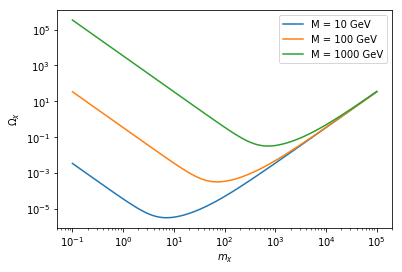

In [3]:
def freezeNonRel(x, mass,mz):
    return np.sqrt(x)*np.exp(-x)  - 1/(mass * M_pl * crossSec(mass, mz))

def xFreezeNonRel(mass, mz):
    x0 = 10
    x = []
    for m in mass:
        x.append(newton(freezeNonRel, x0, args = (m,mz), maxiter = 10000))
    return x
    
def RelicDensityNonRel(mass, mz):
    pc = 1.055e-5 /(5.06e13**3) #GeV
    T0 = 2.75e-13 #GeV
    xf = xFreezeNonRel(mass, mz)
    for x in xf:
        r = (x * T0**3) / (M_pl * crossSec(mass, mz) * pc)
    return r

def crossSec(mass, mz):
    return mass**2 / (((mass+mz)**2 - mz**2)**2 + mz**4)
    

mass = np.logspace(-1, 5, 100)
plt.loglog(mass, RelicDensityNonRel(mass, 10), label = 'M = 10 GeV')
plt.loglog(mass, RelicDensityNonRel(mass, 100), label = 'M = 100 GeV')
plt.loglog(mass, RelicDensityNonRel(mass, 1000), label = 'M = 1000 GeV')
plt.xlabel('$m_\chi$')
plt.ylabel('$\Omega_\chi h^2$')
plt.legend()
plt.show()

### Relativistic Case
The relativistic case is more trivial to solve. The number density is given by
$$
n = \frac{\zeta(3)}{\pi^2} g T^3
$$
with an addition factor of $3/4$ for fermions. 

$x_{f.o.}$ can be analitically solved as 
$$
T = \frac{\pi^3}{3}\frac{1}{\sqrt{10g_*}} \frac{1}{M_p <\sigma v>} 
$$
Converting this into $x$ is not trivial. 

In the relativistic case, we can approximate the cross section $\sigma \sim 1/m_\chi^2$. We show that there is no longer a dependence on the mass of the propagator. Using equipartition, I have set
$$
v \sim \sqrt{\frac{3 k_b T}{m_\chi}}
$$
We have not plotted any different value of the propagator as it is no longer relevant at the relativistic scale. To compute the relic density we use 
$$
\Omega_\chi = \frac{m_\chi \cdot n_\chi(T=T_0)}{\rho_c}
$$
we compute $x_{f.o.}$ for different masses of the dark matter particle.

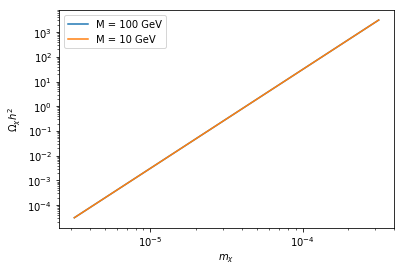

In [7]:
def number_density(mass, T):
    '''Number density at equilibrium'''
    return (g_star(T) * (T)**3)/np.pi**2

def xFreezeRel(mass):
    x = []
    for m in mass:
        T = (np.pi**3 / 3 * np.sqrt(1/10*106.25) * 1/(m**(-2)*(np.sqrt(3 *8.61e-14/m))*M_pl))**(2/3)
        x.append(m / T)
    return x

def RelicDensityRel(mass, mz):
    pc = 1.055e-5 /(5.06e13**3) #GeV
    xf = xFreezeRel(mass)
    for x in xf:
        r = (mass * number_density(mass, mass/x)) / (pc)
    return r

mass = np.logspace(-5.5, -3.5, 100)
plt.loglog(mass, RelicDensityRel(mass, 100), label='M = 100 GeV')
plt.loglog(mass, RelicDensityRel(mass, 10), label='M = 10 GeV')
plt.xlabel('$m_\chi$')
plt.ylabel('$\Omega_\chi h^2$')
plt.legend(loc='best')

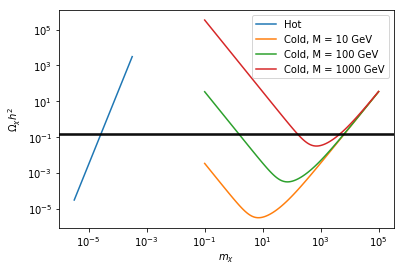

In [22]:
mass = np.logspace(-5.5, -3.5, 100)
plt.loglog(mass, RelicDensityRel(mass, 100), label = 'Hot')
mass = np.logspace(-1, 5, 100)
plt.loglog(mass, RelicDensityNonRel(mass, 10), label = 'Cold, M = 10 GeV')
plt.loglog(mass, RelicDensityNonRel(mass, 100), label = 'Cold, M = 100 GeV')
plt.loglog(mass, RelicDensityNonRel(mass, 1000), label = 'Cold, M = 1000 GeV')
ax = plt.gca()
ax.axhline(0.135+0.008, color = 'black')
ax.axhline(0.135-0.009, color = 'black')
plt.xlabel('$m_\chi$')
plt.ylabel('$\Omega_\chi h^2$')
plt.legend(loc='best')
plt.show()

We can see a 'Hot' regime where there is a linear dependence for $\Omega_\chi$ on $m_\chi$, with no dependence on the mass of the propagator.. Then we see the 'Cold' regime where $\Omega_\chi$ has a different dependence. As explained, it is related to the mass of the progator in the cross section. The black line indicates the currently measured Relic Density.

### Non-instanteneous freezeout

Freeze-out is not an instanteneous process. Following Steigman (see https://arxiv.org/pdf/1204.3622.pdf), we want to the following differential equation

$$
\frac{dY}{dx} = \frac{\lambda}{x^2} ( 1 + \frac{1}{3} \frac{d(\log g_s)}{d(\log T)} ) \frac{g_s}{g_\rho^{1/2}}(Y_{\text{eq}}^2-Y^2)
$$

We neglect the $\frac{1}{3} \frac{d(\log g_s)}{d(\log T)}$ term as in Steigman and set $\frac{g_s}{g_\rho^{1/2}}$ to 1. The formula reduces to:

$$
\frac{dY}{dx} = \frac{\lambda}{x^2}(Y_{\text{eq}}^2-Y^2)
$$

where $Y$ is defined as the number density divided by the entropy density, en 'eq' stands for equilibrium. We use $\lambda$ as in Steigman, with $\lambda = 2.76 \times 10^{35}m\langle \sigma v \rangle$. To solve the differential equation we follow Steigman's substitution with $W = \ln(Y)$. We get the following formula that will be solved for $x$.

$$
\frac{dW}{dx} = \frac{\lambda}{x^2}(e^{2W_{\text{eq}} - W} - e^{W})
$$

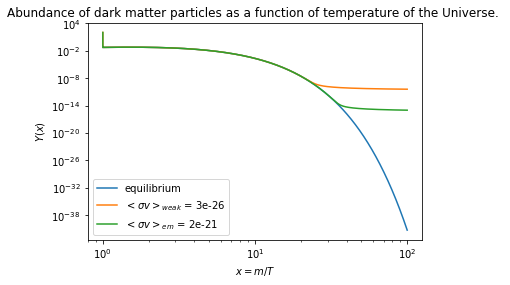

In [23]:
plt.clf() #clear previous figure

def dWdx(W, x, sigv, mass):
    labda = 2.76e35 * mass * sigv
    W_eq = np.log(0.145 * x**(3/2) * np.exp(-x))
    dWdx = labda / x**2 * (np.exp(2*W_eq-W) - np.exp(W))
    return dWdx

def getW(sigv, mass, xlist = None):
    '''Solves dWdx'''
    if xlist is None:
        xlist = np.logspace(0,3,1000)
    W0 = np.log(100)
    W = odeint(dWdx, W0, xlist, args = (sigv, mass))[:,0]
    return W

def yeq(x):
    # at equilibrium, see Steigman
    return 0.145 * x**(3/2) * np.exp(-x)

mass = 100 # assume mass of 100 GeV
xspace = np.logspace(0,2,10000) # x between 1 and 100
plt.loglog(xspace,yeq(xspace), label='equilibrium')

sigv = 3e-26 # weak
W = getW(sigv, mass,xspace)
plt.loglog(xspace, np.exp(W), label='$ <\sigma v>_{weak}$ = ' + str(sigv))

sigv = 2e-21 # EM
W = getW(sigv, mass,xspace)
plt.loglog(xspace, np.exp(W), label='$ <\sigma v>_{em}$ = ' + str(sigv))

plt.ylabel('$Y(x)$')
plt.xlabel('$x=m/T$')
plt.legend(loc='best')
plt.title('Abundance of dark matter particles as a function of temperature of the Universe. ')
plt.show()


The plot clearly shows that different cross sections, cause the freeze-out to occur at different temperatures and times. The larger the cross-section, the later the freeze-out start and the higher the relic density. 
